CODE BLOCK: 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GitHub/ERA-V1/Assignments/S5

Mounted at /content/drive
/content/drive/MyDrive/GitHub/ERA-V1/Assignments/S5


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# New Section

CODE BLOCK: 2

In [3]:
# CUDA?
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [5]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [6]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

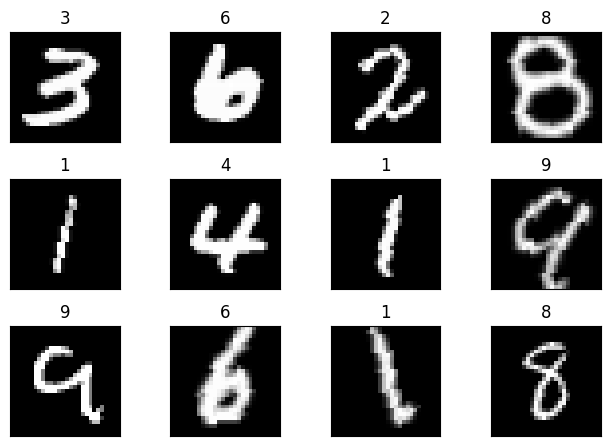

In [7]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [8]:
# class Net(nn.Module):
#     #This defines the structure of the NN.
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
#         self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x), 2)
#         x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
#         x = F.relu(self.conv3(x), 2)
#         x = F.relu(F.max_pool2d(self.conv4(x), 2)) 
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

In [9]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/GitHub/ERA-V1/Assignments/S5')
sys.path

['/content/drive/MyDrive/GitHub/ERA-V1/Assignments/S5',
 '/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython']

In [10]:
import model
network = model.Net()

In [11]:
%pycat model.py

In [12]:
print(network)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4096, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


CODE BLOCK: 8

In [13]:
# # Data to plot accuracy and loss graphs
# train_losses = []
# test_losses = []
# train_acc = []
# test_acc = []

# test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [14]:
%%writefile utils.py
import torch
from tqdm import tqdm

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}
def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  #train_losses = []
  #train_acc = []
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    #test_losses = []
    #test_acc = []
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


Overwriting utils.py


In [15]:
%pycat utils.py

In [16]:
from utils import *

In [17]:

# from tqdm import tqdm

# def GetCorrectPredCount(pPrediction, pLabels):
#   return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# def train(model, device, train_loader, optimizer, criterion):
#   model.train()
#   pbar = tqdm(train_loader)

#   train_loss = 0
#   correct = 0
#   processed = 0

#   for batch_idx, (data, target) in enumerate(pbar):
#     data, target = data.to(device), target.to(device)
#     optimizer.zero_grad()

#     # Predict
#     pred = model(data)

#     # Calculate loss
#     loss = criterion(pred, target)
#     train_loss+=loss.item()

#     # Backpropagation
#     loss.backward()
#     optimizer.step()
    
#     correct += GetCorrectPredCount(pred, target)
#     processed += len(data)

#     pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

#   train_acc.append(100*correct/processed)
#   train_losses.append(train_loss/len(train_loader))

# def test(model, device, test_loader, criterion):
#     model.eval()

#     test_loss = 0
#     correct = 0

#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(test_loader):
#             data, target = data.to(device), target.to(device)

#             output = model(data)
#             test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

#             correct += GetCorrectPredCount(output, target)


#     test_loss /= len(test_loader.dataset)
#     test_acc.append(100. * correct / len(test_loader.dataset))
#     test_losses.append(test_loss)

#     print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 10

In [18]:
model = network.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.4038 Batch_id=117 Accuracy=49.87: 100%|██████████| 118/118 [00:33<00:00,  3.52it/s]


Test set: Average loss: 0.0006, Accuracy: 9040/10000 (90.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0942 Batch_id=117 Accuracy=93.94: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s]


Test set: Average loss: 0.0002, Accuracy: 9622/10000 (96.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1500 Batch_id=117 Accuracy=96.37: 100%|██████████| 118/118 [00:25<00:00,  4.69it/s]


Test set: Average loss: 0.0002, Accuracy: 9670/10000 (96.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1139 Batch_id=33 Accuracy=96.67:  29%|██▉       | 34/118 [00:07<00:18,  4.46it/s]


KeyboardInterrupt: ignored

CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

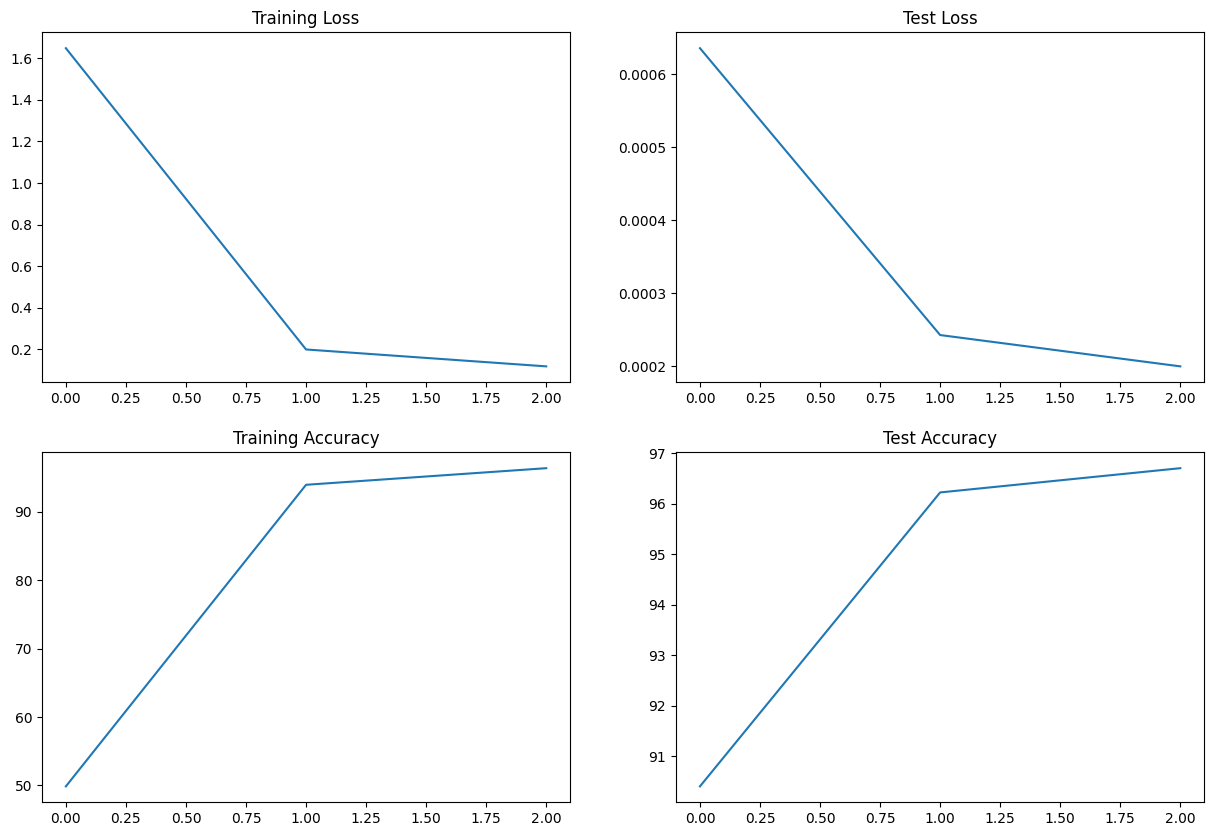

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [16]:
!pip install torchsummary
!pip install torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# model = Net().to(device)
# summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
